# This Notebook is my First Submission into Kaggle Toxic Comment Classification Challege

In [53]:
#import dependencies
import numpy as np
import pandas as pd
import re
import h5py
import unidecode
from tqdm import tqdm
import matplotlib
% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Conv1D, Dropout, Flatten, BatchNormalization
from keras.models import Model
from keras import metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from scipy.sparse import vstack

We start by importing the train and test data and print the first 10 rows

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [5]:
#There are 159571 rows in train set
train.shape

(159571, 8)

In [6]:
levels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [7]:
#summing the toxicity levels so that we can easily divide the train data to K folds.
train['sum_level'] = train[levels[0]] + train[levels[1]] + train[levels[2]] + train[levels[3]] + train[levels[4]] + train[levels[5]]

Let us now find the number of train data we have for each toxicity level

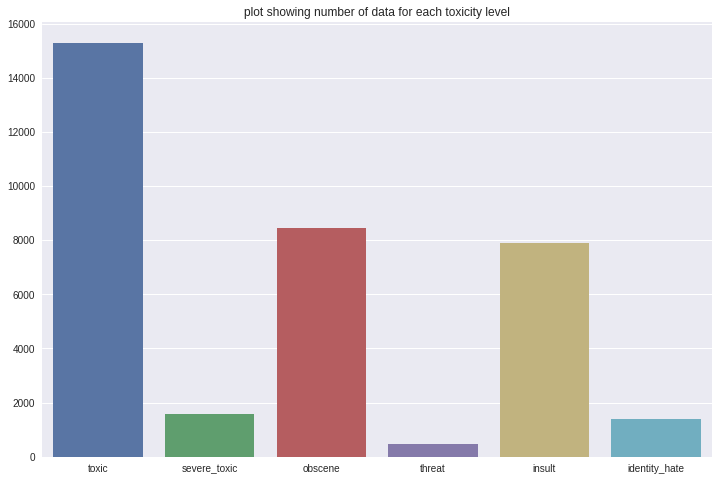

In [8]:
y_axis = []
for i in levels:
    y_axis.append(train[i].value_counts()[1])
plt.figure(figsize=(12,8))
sns.barplot(x = levels, y=y_axis)
plt.title("plot showing number of data for each toxicity level")
plt.show()

Also it is worth noting that there can be multiple toxicity level for a single data point. Let us now check the correlation between different toxicity levels.

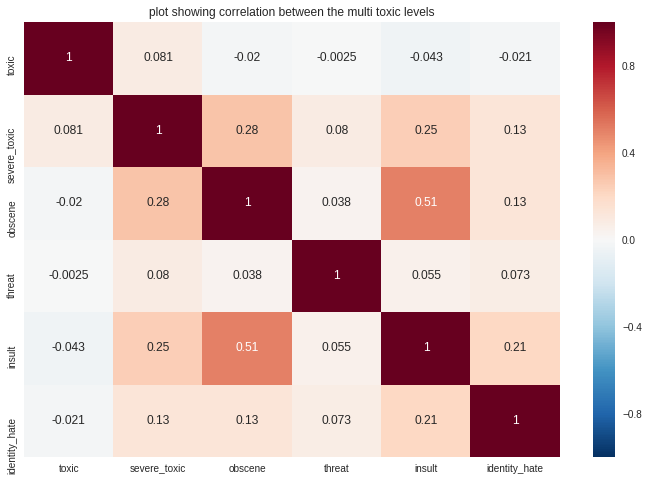

In [9]:
plt.figure(figsize=(12,8))
correlation_matrix = train[train['sum_level']>0].iloc[:,2:-1].corr()
sns.heatmap(np.array(correlation_matrix), annot=True, cbar=True,xticklabels=levels,yticklabels=levels)
plt.title('plot showing correlation between the multi toxic levels')
plt.show()

Let us now move to data cleaning step. We saw that the data was not cleaned at all. There were capital letters in the middle. There were back slashesh everywhere. There were unicode accents.etc.

We removed punctuation as well as all the other symbols and converted the text to lower.

In [10]:
#we see there are many \n characters in text. lets just remove those first
good_text = []
for i in tqdm(train['comment_text']):
    i = re.sub(r'[\n]+', ' ', i)
    i = re.sub(r'\s+', ' ', i)
    good_text.append(i)
train['comment_text'] = good_text

100%|██████████| 159571/159571 [00:07<00:00, 21084.44it/s]


In [11]:
#we see there are many \n characters in text. lets just remove those first
good_text_test = []
for i in tqdm(test['comment_text']):
    i = re.sub(r'[\n]+', ' ', i)
    i = re.sub(r'\s+', ' ', i)
    good_text_test.append(i)
test['comment_text'] = good_text_test

100%|██████████| 153164/153164 [00:07<00:00, 21659.09it/s]


In [7]:
bag_of_words = {}
for i in tqdm(good_text):
    words = i.split(' ')
    for ii in words:
        if ii not in bag_of_words:
            bag_of_words[ii] = 1
        else:
            bag_of_words[ii]+=1

100%|██████████| 159571/159571 [00:05<00:00, 28073.84it/s]


In [8]:
bag_of_words

{'transjordan,': 1,
 'milestone;': 1,
 'others.\xe2\x80\x9d': 2,
 'cords,': 1,
 'Talk:Bhuvanaikabahu': 1,
 '[[\xe2\x84\xa2]]whoever': 2,
 'woods': 13,
 'Catalans.': 1,
 'spiders': 5,
 'Catalans,': 1,
 'zwyke': 1,
 '(hangon)': 1,
 'woody': 2,
 "weren't).": 1,
 'Half-Baked': 1,
 '""especially""': 2,
 'all-new,': 1,
 'canes': 1,
 'clutter"",': 1,
 'canada)': 1,
 'Subscrider': 1,
 '78,79': 1,
 'gab': 1,
 'Sergeant.': 1,
 '""Afro-Nationality""': 1,
 '62.255.32.14': 1,
 'gaa': 3,
 'http://rexcurry.net/pledge1.html': 6,
 'Eurm': 1,
 'Euro': 25,
 'Czolgoz.': 1,
 'wood!': 1,
 'partyjniak': 1,
 'Y1.': 1,
 "Zion,'": 1,
 'Issaac': 1,
 'spider.': 1,
 'wood)': 1,
 'spider,': 2,
 'Secularism': 2,
 'deletion==': 3,
 'wood.': 3,
 'pigment': 3,
 'B->C,': 1,
 '""corrected""': 4,
 'Vally': 1,
 'comptuer': 1,
 'Lajoie': 1,
 'BSD,': 1,
 'BSD.': 1,
 'biennial.': 1,
 '""Bieszczady""': 1,
 'Qazan': 1,
 'weell': 1,
 "Sakura's": 3,
 '":::::A': 1,
 'wooden': 20,
 'milestone,': 2,
 '(Live)': 3,
 'Wikipedia:EL#Link

In [9]:
#so many unique words is not a good idea
len(bag_of_words)

533185

In [12]:
#let us strip the unicode accents

good_text = []
for i in tqdm(train['comment_text']):
    i = unicode(i, 'utf-8')
    i = unidecode.unidecode(i)
    good_text.append(i)
train['comment_text'] = good_text


good_text_test = []
for i in tqdm(test['comment_text']):
    i = unicode(i, 'utf-8')
    i = unidecode.unidecode(i)
    good_text_test.append(i)
test['comment_text'] = good_text_test

100%|██████████| 153164/153164 [00:07<00:00, 19823.57it/s]


In [13]:
#make whole string lower
#replace \'s and 's with is
#replace \'t and 't with not
#replace \'re and 're with are
#replace w'd with would
#replace \'d and d with would
#replace \'ll and 'll with will
#replace i\'m and i'm with i am
#replce \'pedia and 'pedia with wikipedia
#replace https://www. with www
# replace www. with www
# replace .com with com
#replace['[\[ \] \. " # \$ % \^ \* \( \) \? \\ / @ < > _ : = \+ \{ } \| ~ ! , \'] with spaces
#finally remove all extra spaces and remove tailing and starting spaces


good_text = []
for i in tqdm(train['comment_text']):
    i = i.lower()
    i = re.sub(r'\\\'s', ' is', i)
    i = re.sub(r'\'s', ' is', i)
    
    i = re.sub(r'can\\\'t', 'can not', i)
    i = re.sub(r'can\'t', 'can not', i)
    
    i = re.sub(r'n\\\'t', ' not', i)
    i = re.sub(r'n\'t', ' not', i)
    
    i = re.sub(r'\\\'nt', ' not', i)
    i = re.sub(r'\'nt', ' not', i)
    
    i = re.sub(r'\\\'re', ' are', i)
    i = re.sub(r'\'re', ' are', i)
    
    i = re.sub(r'\s[w]\'d', ' would', i)
    i = re.sub(r'\\\'d', ' would', i)
    i = re.sub(r'\'d', ' would', i)
    
    i = re.sub(r'\\\'ll', ' will', i)
    i = re.sub(r'\'ll', ' will', i)
    
    i = re.sub(r'i\\\'m', ' i am ', i)
    i = re.sub(r'i\'m', ' i am ', i)
    
    i = re.sub(r'\\\'pedia', ' wikipedia ', i)
    i = re.sub(r'\'pedia', ' wikipedia ', i)
    
    i = re.sub(r'https://www\.', ' www ', i)
    i = re.sub(r'www\.', ' www ', i)
    
    i = re.sub(r'\.com', ' com ', i)
    
    i = re.sub(r'[-]+', ' ', i)
    
    i = re.sub(r'[\[ \] \. " # \$ % \^ \* \( \) \? \\ / @ < > _ : = \+ \{ } \| ~ ! , \']+', ' ', i)
    
    i = re.sub(r'\s+', ' ', i)
    
    i = i.strip()
    
    good_text.append(i)
train['comment_text'] = good_text




good_text_test= []
for i in tqdm(test['comment_text']):
    i = i.lower()
    i = re.sub(r'\\\'s', ' is', i)
    i = re.sub(r'\'s', ' is', i)
    
    i = re.sub(r'can\\\'t', 'can not', i)
    i = re.sub(r'can\'t', 'can not', i)
    
    i = re.sub(r'n\\\'t', ' not', i)
    i = re.sub(r'n\'t', ' not', i)
    
    i = re.sub(r'\\\'nt', ' not', i)
    i = re.sub(r'\'nt', ' not', i)
    
    i = re.sub(r'\\\'re', ' are', i)
    i = re.sub(r'\'re', ' are', i)
    
    i = re.sub(r'\s[w]\'d', ' would', i)
    i = re.sub(r'\\\'d', ' would', i)
    i = re.sub(r'\'d', ' would', i)
    
    i = re.sub(r'\\\'ll', ' will', i)
    i = re.sub(r'\'ll', ' will', i)
    
    i = re.sub(r'i\\\'m', ' i am ', i)
    i = re.sub(r'i\'m', ' i am ', i)
    
    i = re.sub(r'\\\'pedia', ' wikipedia ', i)
    i = re.sub(r'\'pedia', ' wikipedia ', i)
    
    i = re.sub(r'https://www\.', ' www ', i)
    i = re.sub(r'www\.', ' www ', i)
    
    i = re.sub(r'\.com', ' com ', i)
    
    i = re.sub(r'[-]+', ' ', i)
    
    i = re.sub(r'[\[ \] \. " # \$ % \^ \* \( \) \? \\ / @ < > _ : = \+ \{ } \| ~ ! , \']+', ' ', i)
    
    i = re.sub(r'\s+', ' ', i)
    
    i = i.strip()
    
    good_text_test.append(i)
test['comment_text'] = good_text_test

100%|██████████| 153164/153164 [00:34<00:00, 4388.62it/s]


In [12]:
bag_of_words = {}
for i in tqdm(good_text):
    words = i.split(' ')
    for ii in words:
        if ii not in bag_of_words:
            bag_of_words[ii] = 1
        else:
            bag_of_words[ii]+=1

100%|██████████| 159571/159571 [00:08<00:00, 19381.93it/s]


In [17]:
bag_of_words

{'tsukino': 1,
 'unsupportable': 12,
 'bailyite': 1,
 'sowell': 2,
 'woods': 60,
 'spiders': 9,
 'gavan': 2,
 'zwyke': 1,
 'ultimatley': 1,
 'woody': 28,
 'trawling': 13,
 'comically': 4,
 '027597675': 1,
 'regularize': 1,
 'alwiqi': 1,
 'sprague': 2,
 'caney': 2,
 'jairam': 1,
 'acurately': 1,
 'supasoldier': 1,
 'falseinformation': 1,
 'rickman': 1,
 'riconferma': 3,
 'riconferme': 2,
 'naturopathic': 16,
 'sidestrand': 4,
 'pigment': 5,
 'occops': 1,
 'tijfo098': 1,
 'bringing': 325,
 'raviah': 1,
 'jrpg': 3,
 'tcby': 1,
 'wooded': 3,
 'receiving': 242,
 'kangema': 1,
 'wooden': 26,
 'kacian': 3,
 'wednesday': 57,
 'hsu': 4,
 'virtuosos': 1,
 'chameleons': 3,
 'elgar': 4,
 'amplifications': 1,
 'immunities': 1,
 'sekgathe': 1,
 'thrace': 28,
 'thecyclothymiacollective': 1,
 'jmorrison230582': 1,
 'estonisans': 1,
 'thraco': 6,
 '270': 19,
 '271': 8,
 '272': 7,
 '273': 8,
 '274': 7,
 '275': 13,
 'sh1t': 3,
 '277': 17,
 '278': 6,
 '279': 4,
 '27;': 2,
 'v&m;': 1,
 'tumen': 2,
 'philli

In [14]:
len(bag_of_words)

190634

WordCloud is also a very important step in text data analysis. Here from the data we can see that thet toxic comments have specific words that would not be there in non toxic comments

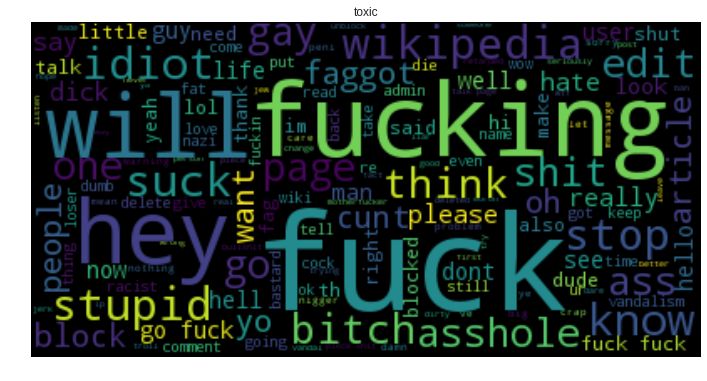

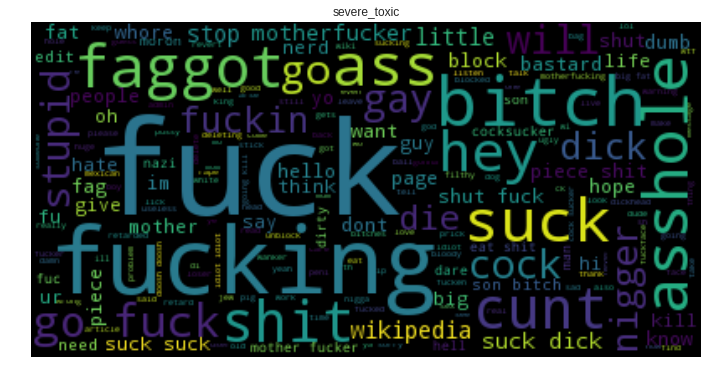

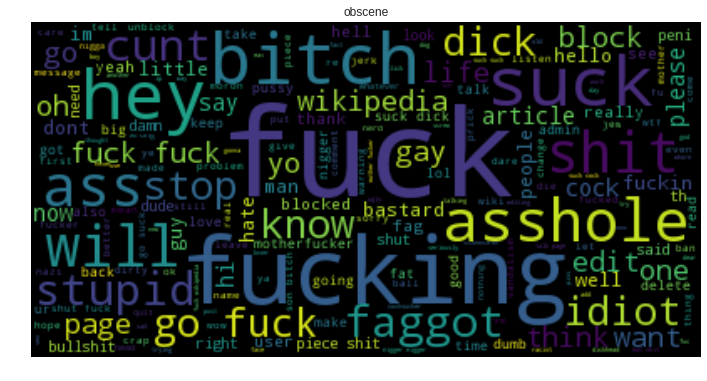

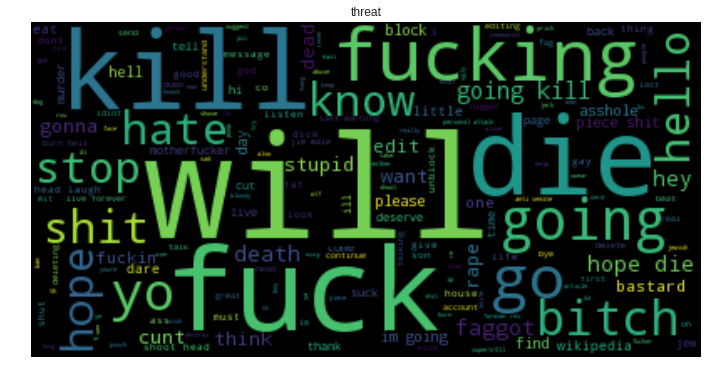

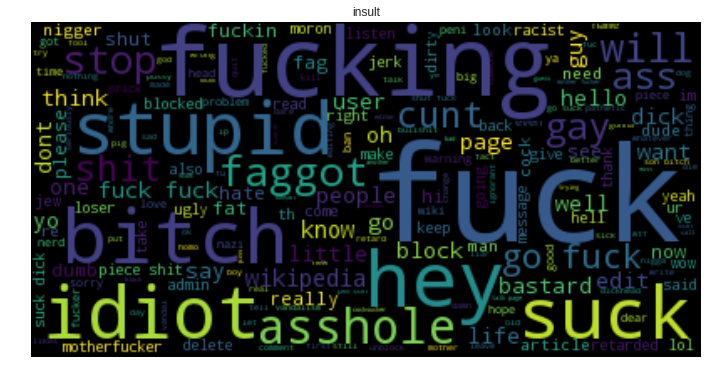

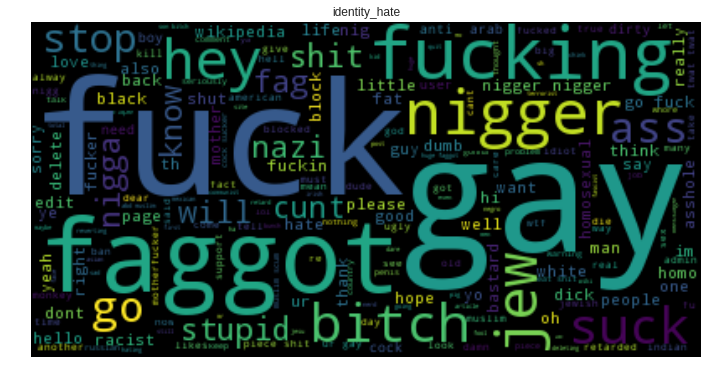

In [14]:
# show word clouds of all levels of toxic words
stop_words = set(STOPWORDS)


for i in levels:
    plt.figure(figsize=(12,8))
    wordcloud = WordCloud(stopwords=stop_words).generate(train[train[i]==1]['comment_text'].to_string())
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(i)
plt.show()

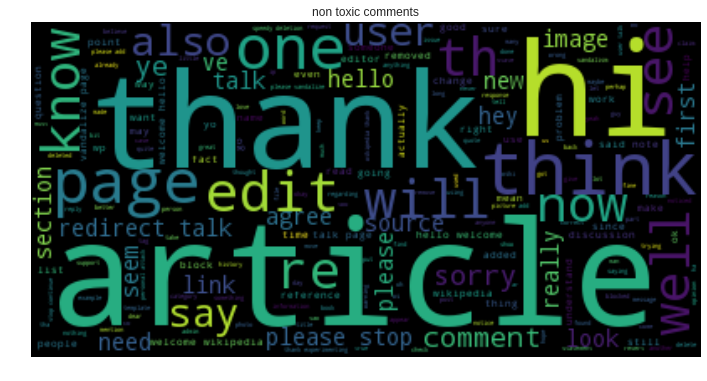

In [35]:
plt.figure(figsize=(12,8))
wordcloud = WordCloud(stopwords=stop_words).generate(train[train['sum_level']==0]['comment_text'].to_string())
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('non toxic comments')
plt.show()

In [35]:
#check the frequency of common words collected through word cloud
print("Fucking: " + str(bag_of_words['fucking']))
print("Fuck: " + str(bag_of_words['fuck']))
print("will: " + str(bag_of_words['will']))
print("stupid: " + str(bag_of_words['stupid']))
print("wikipedia: " + str(bag_of_words['wikipedia']))
print("shit: " + str(bag_of_words['shit']))
print("kill: " + str(bag_of_words['kill']))
print("die: " + str(bag_of_words['die']))
print("faggot: " + str(bag_of_words['faggot']))
print("nigger: " + str(bag_of_words['nigger']))

Fucking: 3408
Fuck: 10088
will: 38308
stupid: 2053
wikipedia: 48561
shit: 3885
kill: 1133
die: 2495
faggot: 2039
nigger: 3361


After the cleaning step we start witht he transformtion step. The algorithm that works most of the time for text data is TFIDF. But TFIDF will output a very high dimensional data. So we need to apply dimensionality reduction to the output. Here we used T-SVD which works best for text data.

We will apply TFIDF to Characters as well as Words

In [31]:
all_text = pd.concat([train['comment_text'], test['comment_text']])

In [32]:
tfidf = TfidfVectorizer(analyzer='char', ngram_range=(1,5),max_df=0.5, min_df=0.001)
tfidf.fit(all_text)
tfidf_train_1 = tfidf.transform(train['comment_text'])
tfidf_test_1 = tfidf.transform(test['comment_text'])

In [33]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,2),lowercase=False,token_pattern = '\w{1,}', max_df=0.5, min_df=0.001)
tfidf.fit(all_text)
tfidf_train_2 = tfidf.transform(train['comment_text'])
tfidf_test_2 = tfidf.transform(test['comment_text'])

In [54]:
tfidf_1 = vstack((tfidf_train_1,tfidf_test_1))
tfidf_2 = vstack((tfidf_train_2,tfidf_test_2))

In [57]:
#We cannot use the whole set for deep learning. so lets reduce the dimensions using T-SVD
tsvd = TruncatedSVD(n_components=200,n_iter=10, random_state=2018)
tsvd1 = TruncatedSVD(n_components=200,n_iter=10, random_state=2018)
tsvd.fit(tfidf_1)

tfidf_train_1 = tsvd.transform(tfidf_train_1)
tfidf_test_1 = tsvd.transform(tfidf_test_1)

tsvd1.fit(tfidf_2)

tfidf_train_2 = tsvd1.transform(tfidf_train_2)
tfidf_test_2 = tsvd1.transform(tfidf_test_2)

In [58]:
#saving the tfidf data so that i donot need to run these code again
np.savetxt('train_tfidf_data_1.txt', tfidf_train_1)
np.savetxt('test_tfidf_data_1.txt', tfidf_test_1)

np.savetxt('train_tfidf_data_2.txt', tfidf_train_2)
np.savetxt('test_tfidf_data_2.txt', tfidf_test_2)

In [74]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_train_1, np.array(train.iloc[:,2:-1]),test_size=0.3, random_state=2018, stratify = train['sum_level'])

In [86]:
#now we are ready for Deep learning. Wanted to start with boosting, but lets strt with DL. 
#we will start with a simple keras model

#considering text data let us start with a simple fully connected model


#starting keras model with tensorflow backend

inputs = Input(shape=(200,))

a = Dense(1024,activation='relu', input_shape=(None,200))(inputs)
a = Dropout(0.5)(a)
a = Dense(512, activation='relu')(a)
a = Dropout(0.5)(a)
a = Dense(256, activation='relu')(a)
a = Dropout(0.5)(a)
a = Dense(128, activation='relu')(a)
a = Dropout(0.5)(a)
output= Dense(6, activation='softmax')(a)


model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=[metrics.categorical_accuracy])

mck = ModelCheckpoint('sub1.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
estop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='auto')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              205824    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
__________

In [ ]:
model.fit(x_train,y_train,epochs=200, batch_size=10, verbose=1, shuffle=True, validation_split=0.3, callbacks=[mck,estop])

Train on 78189 samples, validate on 33510 samples
Epoch 1/200
78189/78189 [==============================] - 79s - loss: 0.3002 - categorical_accuracy: 0.9640 - val_loss: 0.2923 - val_categorical_accuracy: 0.9882
Epoch 2/200
78189/78189 [==============================] - 101s - loss: 0.2953 - categorical_accuracy: 0.9795 - val_loss: 0.2896 - val_categorical_accuracy: 0.9931
Epoch 3/200
11890/78189 [===>..........................] - ETA: 71s - loss: 0.3040 - categorical_accuracy: 0.9716

In [83]:
model.load_weights('sub1.h5')

In [84]:
from sklearn.metrics import roc_auc_score
y_pred = model.predict(x_test)
score = roc_auc_score(y_test,y_pred,average='weighted')
print(score)

0.575859118418


In [66]:
sub = pd.DataFrame(test['id'])
y_pred = model.predict(tfidf_test_1)

for i in range(len(levels)):
    sub[levels[i]]=y_pred[:,i]

In [67]:
sub.to_csv('first_sub.csv', index=False)

In [68]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_train_2, np.array(train.iloc[:,2:-1]),test_size=0.3, random_state=2018, stratify = train['sum_level'])

In [71]:
model.fit(x_train,y_train,epochs=200, batch_size=1000, verbose=1, shuffle=True, validation_split=0.3, callbacks=[mck,estop])

Train on 78189 samples, validate on 33510 samples
Epoch 1/200
78189/78189 [==============================] - 1s - loss: 0.3182 - categorical_accuracy: 0.9134 - val_loss: 0.2969 - val_categorical_accuracy: 0.9942
Epoch 2/200
78189/78189 [==============================] - 1s - loss: 0.2970 - categorical_accuracy: 0.9929 - val_loss: 0.2918 - val_categorical_accuracy: 0.9942
Epoch 3/200
78189/78189 [==============================] - 1s - loss: 0.2898 - categorical_accuracy: 0.9905 - val_loss: 0.2886 - val_categorical_accuracy: 0.9942
Epoch 4/200
78189/78189 [==============================] - 1s - loss: 0.2874 - categorical_accuracy: 0.9906 - val_loss: 0.2881 - val_categorical_accuracy: 0.9942
Epoch 5/200
78189/78189 [==============================] - 1s - loss: 0.2843 - categorical_accuracy: 0.9902 - val_loss: 0.2882 - val_categorical_accuracy: 0.9941
Epoch 6/200
78189/78189 [==============================] - 1s - loss: 0.2816 - categorical_accuracy: 0.9907 - val_loss: 0.2870 - val_categor

In [ ]:
#1599 on public LB

In [85]:
K.clear_session()